# Моделирование по физике, первое, вторая задача
Макаров Денис Иванович, M3301

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Функции для исполнения
## Функция подсчета "интеграла"
На самом деле, она просто берет сумму "маленьких" прямоугольников
## Загрузка данных
Конфигурация программы строится на основе JSON-файла, называемый `config.json`. Можно заглянуть в его строение, чтобы понять, как можно его задавать
## Загрузка значений потенциальной энергии в пространстве
В зависимости от того, какой тип функции для нас задан для потенциальной энергии, так и определяем его. Заметим, что если задан через пары значений в файле `potential.txt`, то аналитический из `config.json` будет игнорироваться
## Определение вероятности
Потенциальный барьер произвольной формы $\displaystyle U(x)$ можно мысленно разбить на систему стоящих впритык друг к другу прямоугольных барьеров малой ширины ${\displaystyle \Delta x}$ c потенциальной энергией 
${\displaystyle U_{i}.}$ Если пренебречь отражениями на стыках, то коэффициент прохождения такой системы можно вычислить как произведение коэффициентов прохождения всех барьеров из разбиения.

${\displaystyle T=\prod T_{i}=\prod \exp \left(-{\frac {2{\sqrt {2m(U_{i}-E)}}}{\hbar }}\Delta x\right)=\exp \left(-\sum {\frac {2{\sqrt {2m(U_{i}-E)}}}{\hbar }}\Delta x\right).}$


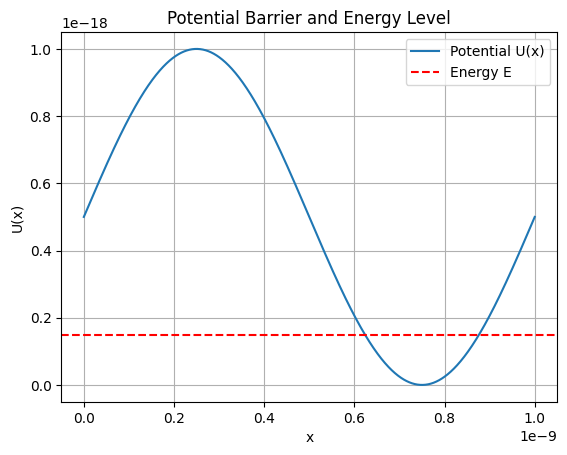

Tunneling probability: 2.1160032681970124e-06


In [23]:
import math

hbar = 1.0545718e-34

def sum_integral(integrand, x_values):
    integrand = np.array(integrand)
    x_values = np.array(x_values)
    widths = np.diff(x_values)
    total_area = np.sum(integrand[:-1] * widths)

    return total_area


def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config

def load_potential(potential_file, analytic_expression=None, x_count=1000):
    potential_data = []
    try:
        with open(potential_file, "r") as f:
            lines = f.readlines()
            for line in lines:
                x, u = map(float, line.split())
                potential_data.append((x, u))
    except FileNotFoundError:
        print(f"Potential file {potential_file} not found. Using analytic expression.")
    if not potential_data and analytic_expression:
        x_values = np.linspace(0, h, x_count)
        potential_data = [(x, analytic_expression(x)) for x in x_values]
    return np.array(potential_data)

def tunneling_probability(m, E, potential):
    x, U = potential[:, 0], potential[:, 1]

    forbidden_region = U > E
    if not np.any(forbidden_region):
        return 1.0
    
    x_forbidden = x[forbidden_region]
    U_forbidden = U[forbidden_region]
    integrand = np.sqrt(2 * m * (U_forbidden - E)) / hbar
    integral = sum_integral(integrand, x_forbidden)
    return np.exp(-2 * integral)

config = load_config("config.json")
m = config["mass"]
E = config["energy"]
h = config["barrier_range"]
x_count = config["x_count"]

analytic_expr = eval("lambda x: " + config["analytic_potential"])

potential = load_potential("potential.txt", analytic_expression=analytic_expr, x_count=x_count)

probability = tunneling_probability(m, E, potential)

plt.plot(potential[:, 0], potential[:, 1], label="Potential U(x)")
plt.axhline(E, color="red", linestyle="--", label="Energy E")
plt.xlabel("x")
plt.ylabel("U(x)")
plt.title("Potential Barrier and Energy Level")
plt.legend()
plt.grid()
plt.show()

print(f"Tunneling probability: {probability}")

# Проведем тесты
1) Первым тестом будет тест на прямоугольный потенциальный барьер. Формула аналитическая для прямоугольного потенциального барьера взята из [Википедии](https://ru.wikipedia.org/wiki/Туннельный_эффект#Прямоугольный_потенциальный_барьер)
2) Второй тест на проход без барьера

К сожалению, тяжело найти другие варианты потенциальных барьеров с их аналитическим решением.

In [4]:
def test_tunneling():
    m = 9.11e-31
    E = 1.5e-19
    U0 = 2.0e-19
    a = 1.0e-11
    x_count = 1000

    def analytic_probability():
        k = np.sqrt(2 * m * (U0 - E)) / hbar
        return 1 / (1 + (U0**2) / (4 * E * (U0 - E)) * np.sinh(k * a)**2)

    def rectangular_barrier(x):
        return U0 if 0 <= x <= a else 0

    x_values = np.linspace(-a, 2 * a, x_count)
    potential_data = [(x, rectangular_barrier(x)) for x in x_values]
    potential = np.array(potential_data)

    numerical_prob = tunneling_probability(m, E, potential)

    analytic_prob = analytic_probability()
    print(f"Numerical tunneling probability: {numerical_prob:.5e}")
    print(f"Analytic tunneling probability:  {analytic_prob:.5e}")

def test_tunneling_empty():
    m = 9.11e-31
    E = 1.5e-19
    U0 = 0
    a = 1.0e-11
    x_count = 1000

    def analytic_probability():
        return 1

    def rectangular_barrier(x):
        return U0 if 0 <= x <= a else 0

    x_values = np.linspace(-a, 2 * a, x_count)
    potential_data = [(x, rectangular_barrier(x)) for x in x_values]
    potential = np.array(potential_data)

    numerical_prob = tunneling_probability(m, E, potential)

    analytic_prob = analytic_probability()
    print(f"Numerical tunneling probability: {numerical_prob:.5e}")
    print(f"Analytic tunneling probability:  {analytic_prob:.5e}")

test_tunneling()
test_tunneling_empty()

Numerical tunneling probability: 9.44366e-01
Analytic tunneling probability:  9.98909e-01
Numerical tunneling probability: 1.00000e+00
Analytic tunneling probability:  1.00000e+00


# Численный метод
Мы решаем одномерное стационарное уравнение Шрёдингера для частицы в потенциальном барьере произвольной формы:
$$\frac{\hbar^2}{2m} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi(x) = E \psi(x)$$
где:

$\hbar$ — приведённая постоянная Планка,
$m$ — масса частицы,
$V(x)$ — потенциал,
$E$ — энергия частицы,
$\psi(x) — волновая функция.
## Дискретизация пространственной области

Мы создаём одномерную сетку по координате $x$ с шагом $dx$:

$$x_i = x_{\text{min}} + i \cdot dx, \quad i = 0, 1, \dots, N-1$$

## Аппроксимация второй производной

Вторая производная волновой функции аппроксимируется с использованием конечных разностей:

$$\frac{d^2 \psi}{dx^2} \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{dx^2}$$

## Формирование матрицы Гамильтониана

Уравнение Шрёдингера приводится к матричному виду:

$$H \psi = E \psi$$

где матрица Гамильтониана $H$ имеет элементы:

На главной диагонали:
$$H_{ii} = - \frac{\hbar^2}{m dx^2} + V_i$$

На побочных диагоналях:
$$H_{i,i+1} = H_{i+1,i} = \frac{\hbar^2}{2m dx^2}$$

Таким образом, матрица $H$ является трёхдиагональной.

## Решение на собственные значения

Находим собственные значения $E_n$ и собственные функции $\psi_n$ матрицы $H$:

$$H \psi_n = E_n \psi_n$$

## Выбор состояния с заданной энергией

Из множества собственных значений выбираем то, которое наиболее близко к заданной энергии $E$:

$$n = \operatorname{argmin}_n |E_n - E|$$

Получаем соответствующую волновую функцию $\psi_n$.

## Нормировка волновой функции

Волновая функция нормируется так, чтобы соблюдалось условие нормировки:

$$\sum_{i=0}^{N-1} |\psi_i|^2 dx = 1$$

## Вычисление вероятностей

Вероятность прохождения ( T ) — вероятность обнаружить частицу в области ( x > 0 ):
$$T = \int_{0}^{\infty} |\psi(x)|^2 dx \approx \sum_{x_i > 0} |\psi_i|^2 dx$$

Вероятность отражения ( R ) — вероятность обнаружить частицу в области ( x < 0 ):
$$R = \int_{-\infty}^{0} |\psi(x)|^2 dx \approx \sum_{x_i < 0} |\psi_i|^2 dx$$

$$T + R = 1$$

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import json
import numexpr as ne

def load_config(filename):
    with open(filename, 'r') as f:
        config = json.load(f)
    return config

def physical_constants(config):
    hbar = 1.0545718e-34  # Дж·с
    m = config.get('mass', 9.10938356e-31)  # кг
    return hbar, m

def spatial_grid(config):
    barrier_range = config.get('barrier_range', 1e-9)
    x_min = -barrier_range
    x_max = 2 * barrier_range
    x_count = config.get('x_count', 10000)
    x = np.linspace(x_min, x_max, x_count)
    dx = x[1] - x[0]
    N = len(x)
    return x, dx, N

def construct_potential(x, config):
    analytic_expr = eval("lambda x: " + config["analytic_potential"])
    return analytic_expr(x)


def construct_hamiltonian(N, V, coeff):
    main_diag = np.full(N, -2 * coeff) + V
    off_diag = np.full(N - 1, coeff)
    H = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    return H

def solve_schrodinger(H):
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    return eigenvalues, eigenvectors

def find_nearest_state(E, eigenvalues, eigenvectors):
    idx = (np.abs(eigenvalues - E)).argmin()
    psi = eigenvectors[:, idx]
    E_calculated = eigenvalues[idx]
    return psi, E_calculated

def normalize_wavefunction(psi, dx):
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dx)
    psi_norm = psi / norm
    return psi_norm

def calculate_probabilities(psi_norm, x, dx, barrier_range):
    T_region = x >= barrier_range
    R_region = x <= 0

    T = np.sum(np.abs(psi_norm[T_region])**2) * dx
    R = np.sum(np.abs(psi_norm[R_region])**2) * dx

    total_probability = T + R
    T /= total_probability
    R /= total_probability

    return T, R

def main():
    config = load_config('config.json')

    hbar, m = physical_constants(config)

    E = config.get('energy', 1e-19)

    barrier_range = config.get('barrier_range', 1e-9)

    x, dx, N = spatial_grid(config)

    try:
        V = construct_potential(x, config)
    except ValueError as e:
        print(e)
        return

    coeff = - hbar**2 / (2 * m * dx**2)

    H = construct_hamiltonian(N, V, coeff)

    eigenvalues, eigenvectors = solve_schrodinger(H)

    psi, E_calculated = find_nearest_state(E, eigenvalues, eigenvectors)
    print(f"Энергия выбранного состояния: {E_calculated} Дж")

    psi_norm = normalize_wavefunction(psi, dx)

    T, R = calculate_probabilities(psi_norm, x, dx, barrier_range)
    print(f"Вероятность прохождения T = {T}")
    print(f"Вероятность отражения R = {R}")
    print(f"Сумма вероятностей T + R = {T + R}")

if __name__ == "__main__":
    main()

Энергия выбранного состояния: 2.2893036919559053e-19 Дж
Вероятность прохождения T = 0.02079167797998308
Вероятность отражения R = 0.9792083220200168
Сумма вероятностей T + R = 0.9999999999999999
